1. Initialization


In [139]:
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import time
import pickle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, auc, RocCurveDisplay, roc_curve
import json
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import seaborn as sns
from featurewiz import featurewiz
from collections import Counter


# folder = os.path.join("/", "Data", "CREMEv2_Result", "20230310", "logs_working", "toTrain")
folder = '../CREME_dataset'
train_technique = ["label_syslog_technique.csv"]
train_lifecycle = ["label_syslog_lifecycle.csv"]
# datas = ["syslog"]


for data in train_technique:
    if os.path.exists(os.path.join(folder, data)):
        print("Path is exists: ", data)
    else:
        print("Path is not exists: ", data)
        
for data in train_lifecycle:
    if os.path.exists(os.path.join(folder, data)):
        print("Path is exists: ", data)
    else:
        print("Path is not exists: ", data)

Path is exists:  label_syslog_technique.csv
Path is exists:  label_syslog_lifecycle.csv


2. Model Definition and Parameters Settings

In [140]:
r_state = 42
core = -1
model = XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core)
max_threshold = 50000
min_threshold = 50

evaluation_data = {}

model_name = list()
for data in train_technique:
    remove_extension = data.split('.')
    name = remove_extension[0].split('_')
    model_filename = 'model_xgboost_{}_{}'.format(name[1], name[-1])
    model_name += [model_filename]

for data in train_lifecycle:
    remove_extension = data.split('.')
    name = remove_extension[0].split('_')
    model_filename = 'model_xgboost_{}_{}'.format(name[1], name[-1])
    model_name += [model_filename]

print(model_name)


['model_xgboost_syslog_technique', 'model_xgboost_syslog_lifecycle']


3. Training and testing (Technique)

Processing dataset:  label_syslog_technique.csv
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (235962, 58)
    Some column names had special characters which were removed...
#### Single_Label Multi_Classification problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Multi_Classifi

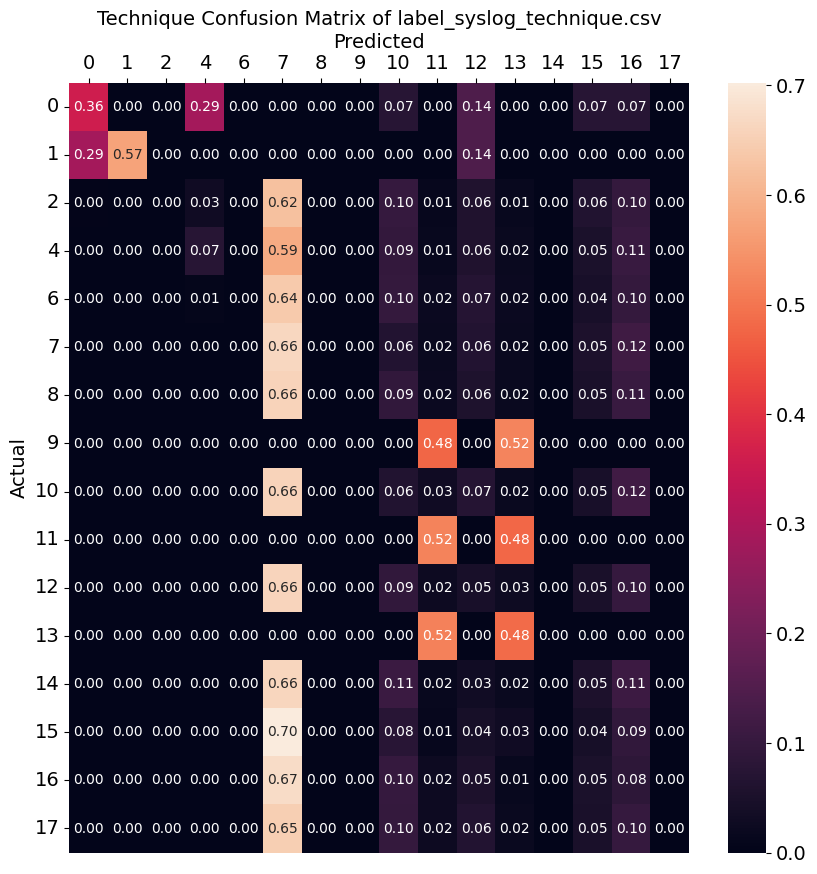

In [141]:
for i, data in enumerate(train_technique):
    print("Processing dataset: ", data)
    start_time = time.time()
    df = pd.read_csv(os.path.join(folder, data))
    model_folder = "model_auroc_combined"

    label_origin = sorted([int(i) for i in df['Label'].unique()])
    le = preprocessing.LabelEncoder()
    le.fit(df['Label'])
    le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

    df = df.drop(columns=['HostName', 'Label_lifecycle', 'Timestamp'])
    feature, df = featurewiz(df, 'Label', corr_limit=0.7, verbose=2, sep=",", header=0, test_data="", feature_engg="", category_encoders="")
    print(feature)
    print(sorted(Counter(df['Label']).items()))

    for label in df['Label'].unique():
        # if too much, try drop duplicated first
        print(len(df[df['Label'] == label]))
        if len(df[df['Label'] == label]) > max_threshold:
            df_tmp = df.loc[df['Label'] == label].copy()
            df_tmp.drop_duplicates(keep='last', inplace=True)
            df.drop(df[df['Label'] == label].index, inplace=True)
            df = pd.concat([df, df_tmp])
            
        # if still too much, randomly picking some of them
        if len(df[df['Label'] == label]) > max_threshold:
            df_tmp = df.loc[df['Label'] == label].copy()
            df_tmp = df_tmp.sample(n=max_threshold, random_state=r_state)
            df.drop(df[df['Label'] == label].index, inplace=True)
            df = pd.concat([df, df_tmp])

        # if too few, double their number until it's enough
        while len(df[df['Label'] == label]) < min_threshold:
            tmp_df = df[df['Label'] == label]
            df = pd.concat([df, tmp_df])

    # feature scaling
    y_tmp = df['Label']
    df.drop(columns=['Label'], inplace=True)
    for feature in df.columns.values:
        scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
        df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
    df = pd.concat([df, y_tmp], axis=1)

    print(sorted(Counter(df['Label']).items()))

    X = df.drop(columns=['Label'])
    X = X.to_numpy()
    # X = X.reshape(-1)
    y = df['Label']
    y = y.to_numpy()
    y = y.reshape(-1)
    y = le.transform(y)
    
    class_label = list(label_origin)

    # print("Train Test Split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=r_state)

    # print("Data balancing")
    X_train, y_train = SMOTE(n_jobs=-1, random_state=r_state).fit_resample(X_train, y_train)
    
    if os.path.exists(os.path.join(model_folder, model_name[i])):
        print("Load ", model_name[i])
        model = pickle.load(open(os.path.join(model_folder, model_name[i]), 'rb'))
    else:
        model.fit(X_train, y_train)
        print("Dump ", model_name[i])
        pickle.dump(model, open(os.path.join(model_folder, model_name[i]), 'wb'))
    y_score = model.predict_proba(X_test)
    y_hat = model.predict(X_test)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    evaluation_data[model_name[i]] = list((y_test, y_onehot_test, y_score))
    end_time = time.time()
    
    print("Execution Time: {:.2f}\n".format(end_time - start_time))

    # Comfusion matrix
    cm = confusion_matrix(y_test, y_hat)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    title = "Technique Confusion Matrix of {}".format(data)

    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label_origin, yticklabels=label_origin)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    plt.title(title, fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show(block=False)

4. Training and testing (Lifecycle)

Processing dataset:  label_syslog_lifecycle.csv
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (235962, 58)
    Some column names had special characters which were removed...
#### Single_Label Multi_Classification problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Multi_Classifi

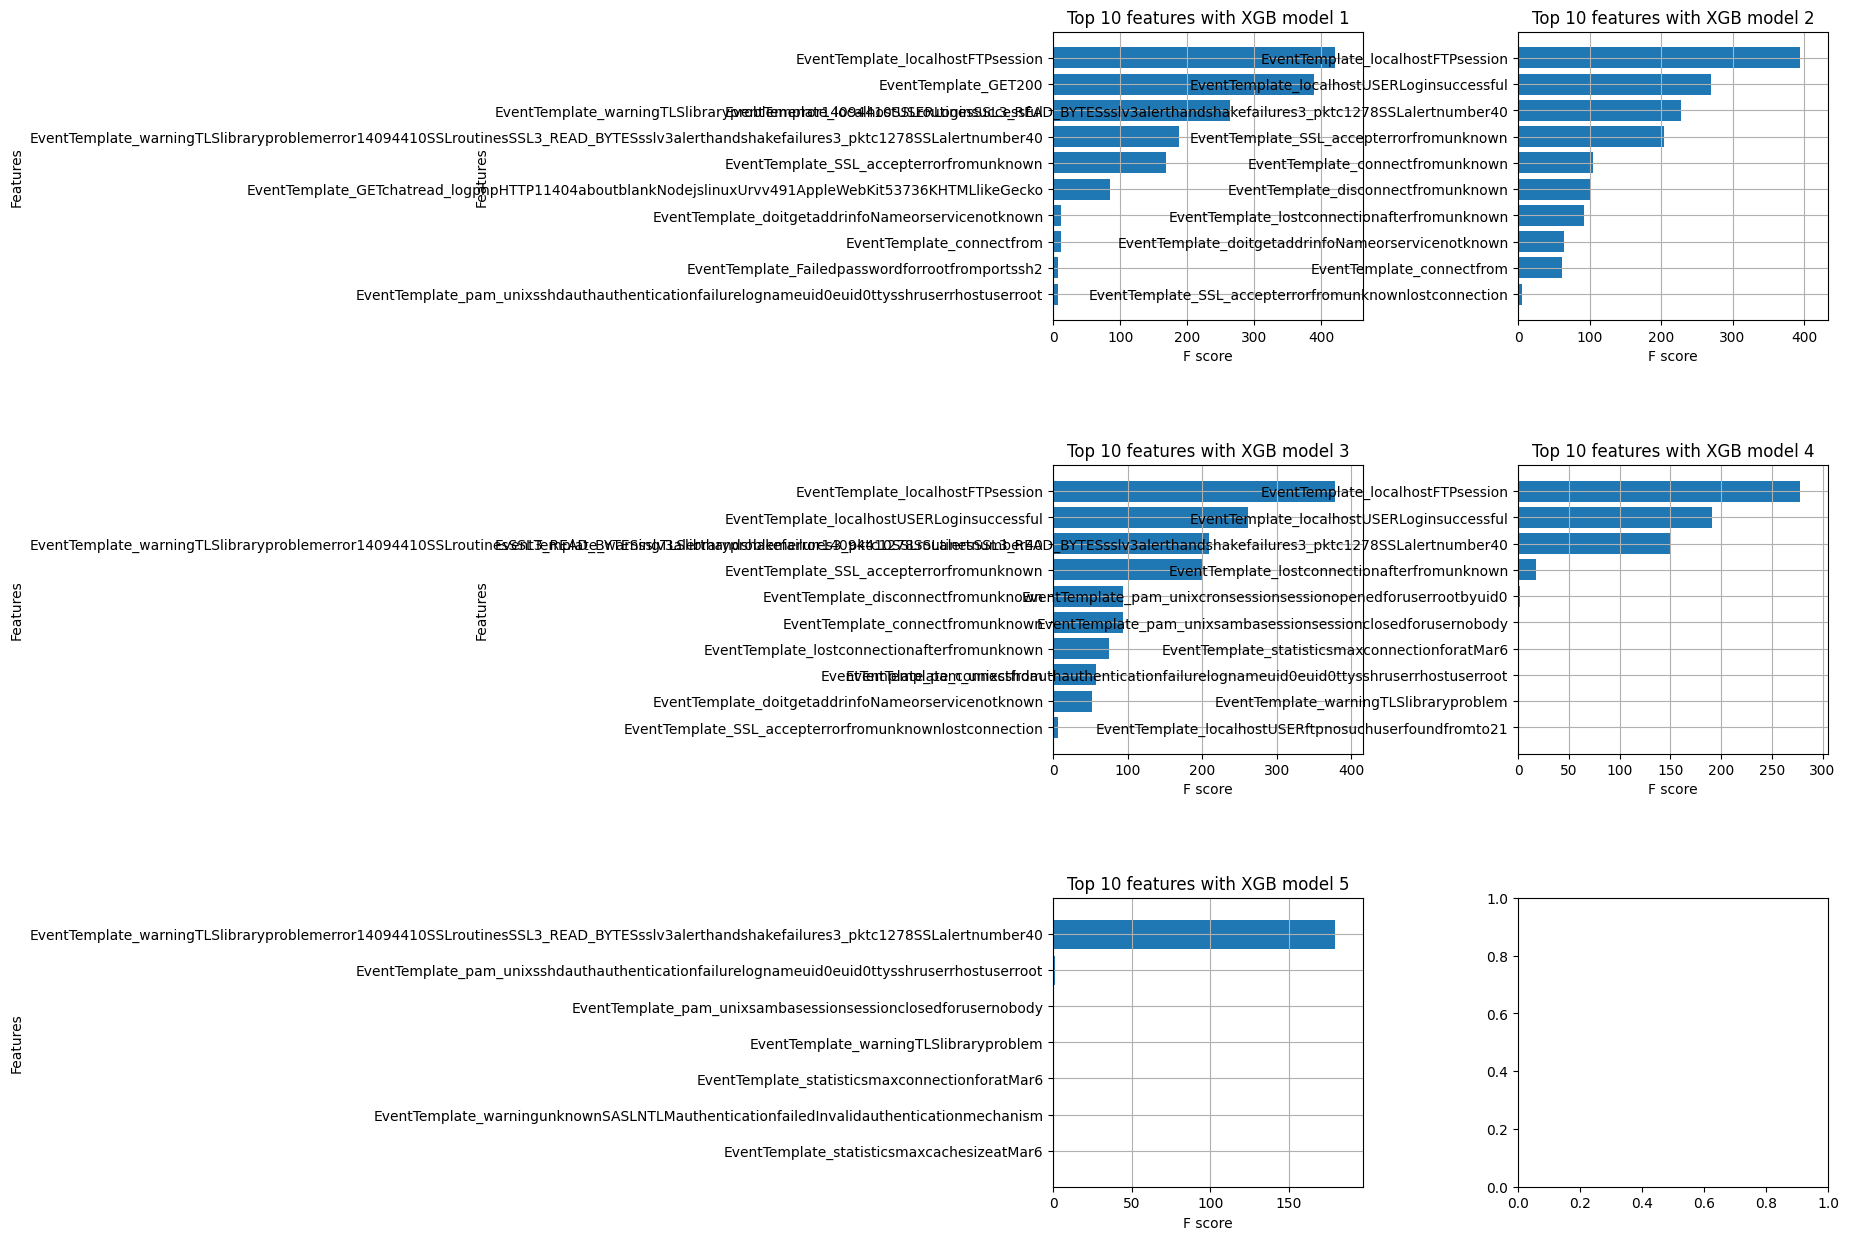

    Completed XGBoost feature selection in 10 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 18 important features:
['EventTemplate_localhostFTPsession', 'EventTemplate_GET200', 'EventTemplate_localhostUSERLoginsuccessful', 'EventTemplate_warningTLSlibraryproblemerror14094410SSLroutinesSSL3_READ_BYTESsslv3alerthandshakefailures3_pktc1278SSLalertnumber40', 'EventTemplate_SSL_accepterrorfromunknown', 'EventTemplate_GETchatread_logphpHTTP11404aboutblankNodejslinuxUrvv491AppleWebKit53736KHTMLlikeGecko', 'EventTemplate_doitgetaddrinfoNameorservicenotknown', 'EventTemplate_connectfrom', 'EventTemplate_disconnectfromunknown', 'EventTemplate_connectfromunknown', 'EventTemplate_lostconnectionafterfromunknown', 'EventTemplate_pam_unixsshdauthauthenticationfailurelog

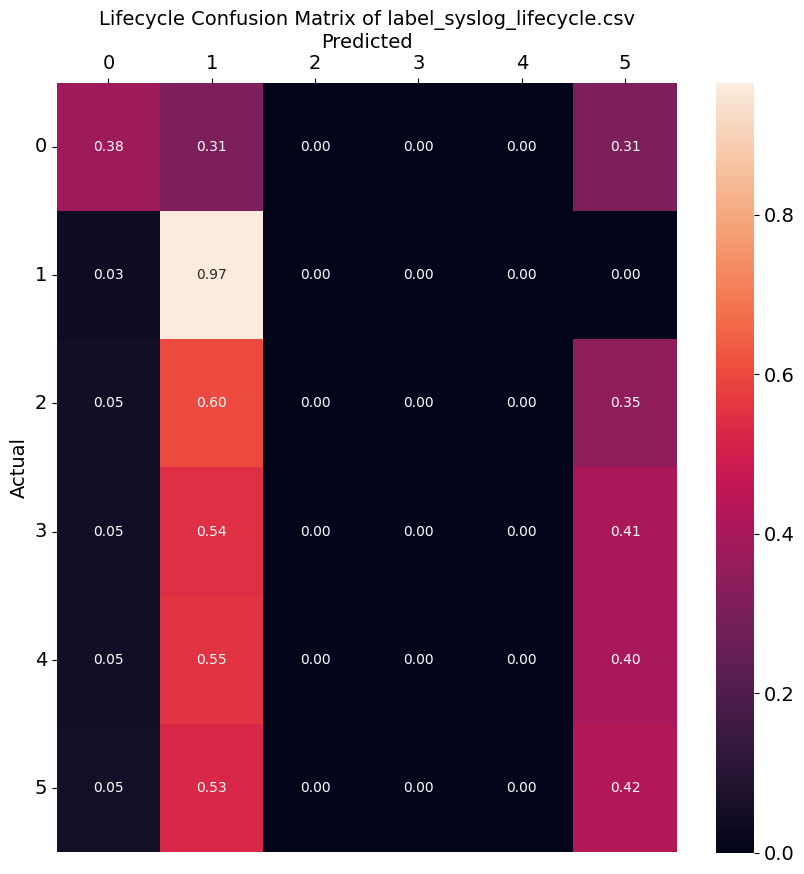

In [142]:
for i, data in enumerate(train_lifecycle):
    print("Processing dataset: ", data)
    start_time = time.time()
    df = pd.read_csv(os.path.join(folder, data))
    model_folder = "model_auroc_combined"

    label_origin = sorted([int(i) for i in df['Label_lifecycle'].unique()])
    le = preprocessing.LabelEncoder()
    le.fit(df['Label_lifecycle'])
    le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

    df = df.drop(columns=['HostName', 'Label', 'Timestamp'])
    feature, df = featurewiz(df, 'Label_lifecycle', corr_limit=0.7, verbose=2, sep=",", header=0, test_data="", feature_engg="", category_encoders="")
    print(feature)

    for label in df['Label_lifecycle'].unique():
        # if too much, try drop duplicated first
        print(len(df[df['Label_lifecycle'] == label]))
        if len(df[df['Label_lifecycle'] == label]) > max_threshold:
            df_tmp = df.loc[df['Label_lifecycle'] == label].copy()
            df_tmp.drop_duplicates(keep='last', inplace=True)
            df.drop(df[df['Label_lifecycle'] == label].index, inplace=True)
            df = pd.concat([df, df_tmp])
            
        # if still too much, randomly picking some of them
        if len(df[df['Label_lifecycle'] == label]) > max_threshold:
            df_tmp = df.loc[df['Label_lifecycle'] == label].copy()
            df_tmp = df_tmp.sample(n=max_threshold, random_state=r_state)
            df.drop(df[df['Label_lifecycle'] == label].index, inplace=True)
            df = pd.concat([df, df_tmp])

        # if too few, double their number until it's enough
        while len(df[df['Label_lifecycle'] == label]) < min_threshold:
            tmp_df = df[df['Label_lifecycle'] == label]
            df = pd.concat([df, tmp_df])

    # feature scaling
    y_tmp = df['Label_lifecycle']
    df.drop(columns=['Label_lifecycle'], inplace=True)
    for feature in df.columns.values:
        scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
        df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
    df = pd.concat([df, y_tmp], axis=1)

    print(sorted(Counter(df['Label_lifecycle']).items()))

    X = df.drop(columns=['Label_lifecycle'])
    X = X.to_numpy()
    # X = X.reshape(-1)
    y = df['Label_lifecycle']
    y = y.to_numpy()
    y = y.reshape(-1)
    y = le.transform(y)
    
    class_label = list(label_origin)



    # print("Train Test Split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=r_state)

    # print("Data balancing")
    X_train, y_train = SMOTE(n_jobs=-1, random_state=r_state).fit_resample(X_train, y_train)
    offset = len(train_technique)
    
    if os.path.exists(os.path.join(model_folder, model_name[i+offset])):
        print("Load ", model_name[i+offset])
        model = pickle.load(open(os.path.join(model_folder, model_name[i+offset]), 'rb'))
    else:
        model.fit(X_train, y_train)
        print("Dump ", model_name[i+offset])
        pickle.dump(model, open(os.path.join(model_folder, model_name[i+offset]), 'wb'))
    y_score = model.predict_proba(X_test)
    y_hat = model.predict(X_test)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    evaluation_data[model_name[i+offset]] = list((y_test, y_onehot_test, y_score))
    end_time = time.time()
    
    print("Execution Time: {:.2f}\n".format(end_time - start_time))

    # Comfusion matrix
    cm = confusion_matrix(y_test, y_hat)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    title = "Lifecycle Confusion Matrix of {}".format(data)

    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label_origin, yticklabels=label_origin)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    plt.title(title, fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show(block=False)

In [143]:
for key, value in evaluation_data.items():
    print(key)
    

model_xgboost_syslog_technique
model_xgboost_syslog_lifecycle


5. Calculate AUROC micro average

In [144]:
roc_data_micro = dict()

for data in model_name:
    # stores all informations
    tpr, fpr, roc_auc = dict(), dict(), dict()
    fpr['micro'],  tpr['micro'], _ = roc_curve(evaluation_data[data][1].ravel(), evaluation_data[data][2].ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
    roc_data_micro[data] = list((fpr['micro'], tpr['micro'], roc_auc['micro']))

    print("Micro average : {:.2f}".format(roc_auc['micro']))


Micro average : 0.63
Micro average : 0.63


6. Calculate AUROC macro average

In [145]:
roc_data_macro = dict()

for data in model_name:
    for i in range(len(class_label)):
        fpr[i], tpr[i], _ = roc_curve(evaluation_data[data][1][:, i], evaluation_data[data][2][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    
    mean_tpr = np.zeros_like(fpr_grid)
    
    skip = 0
    for i in range(len(class_label)):
        inter = np.interp(fpr_grid, fpr[i], tpr[i])
        if np.isnan(inter[0]):
            skip += 1
            continue
        mean_tpr += inter
    
    mean_tpr /= len(class_label) - skip
    
    fpr['macro'] = fpr_grid
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    
    roc_data_macro[data] = list((fpr['macro'], tpr['macro'], roc_auc['macro']))
    
    

    print("Macro average of  : {:.2f}".format(roc_auc['macro']))

Macro average of  : 0.63
Macro average of  : 0.57


7. Plot to diagram

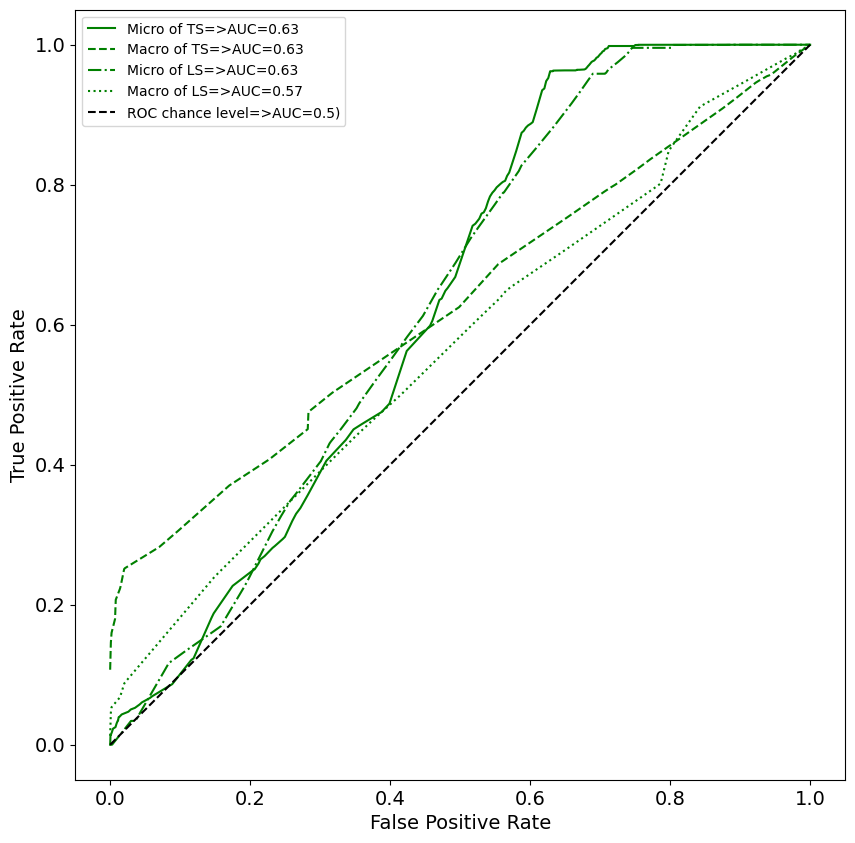

In [146]:


fig, ax = plt.subplots(figsize=(10, 10))
legend_data = ["TA ",
               "TS",
               "TT",
               "LA",
               "LS",
               "LT"
               ]


# plt.plot(
#     roc_data_micro['model_xgboost_accounting_technique'][0],
#     roc_data_micro['model_xgboost_accounting_technique'][1],
#     label="Micro of {}=>AUC={:.2f}".format(legend_data[0], roc_data_micro['model_xgboost_accounting_technique'][2]),
#     color='red', 
#     linestyle='solid'
# )

# plt.plot(
#     roc_data_macro['model_xgboost_accounting_technique'][0],
#     roc_data_macro['model_xgboost_accounting_technique'][1],
#     label="Macro of {}=>AUC={:.2f}".format(legend_data[0], roc_data_macro['model_xgboost_accounting_technique'][2]),
#     color='red',
#     linestyle='dashed'
# )

plt.plot(
    roc_data_micro['model_xgboost_syslog_technique'][0],
    roc_data_micro['model_xgboost_syslog_technique'][1],
    label="Micro of {}=>AUC={:.2f}".format(legend_data[1], roc_data_micro['model_xgboost_syslog_technique'][2]),
    color='green',
    linestyle='solid'
)

plt.plot(
    roc_data_macro['model_xgboost_syslog_technique'][0],
    roc_data_macro['model_xgboost_syslog_technique'][1],
    label="Macro of {}=>AUC={:.2f}".format(legend_data[1], roc_data_macro['model_xgboost_syslog_technique'][2]),
    color='green',
    linestyle='dashed'
)

# plt.plot(
#     roc_data_micro['model_xgboost_traffic_technique'][0],
#     roc_data_micro['model_xgboost_traffic_technique'][1],
#     label="Micro of {}=>AUC={:.2f}".format(legend_data[2], roc_data_micro['model_xgboost_traffic_technique'][2]),
#     color='blue',
#     linestyle='solid'
# )

# plt.plot(
#     roc_data_macro['model_xgboost_traffic_technique'][0],
#     roc_data_macro['model_xgboost_traffic_technique'][1],
#     label="Macro of {}=>AUC={:.2f}".format(legend_data[2], roc_data_macro['model_xgboost_traffic_technique'][2]),
#     color='blue',
#     linestyle='dashed'
# )

# plt.plot(
#     roc_data_micro['model_xgboost_accounting_lifecycle'][0],
#     roc_data_micro['model_xgboost_accounting_lifecycle'][1],
#     label="Micro of {}=>AUC={:.2f}".format(legend_data[3], roc_data_micro['model_xgboost_accounting_lifecycle'][2]),
#     color='red',
#     linestyle='dashdot'
# )

# plt.plot(
#     roc_data_macro['model_xgboost_accounting_lifecycle'][0],
#     roc_data_macro['model_xgboost_accounting_lifecycle'][1],
#     label="Macro of {}=>AUC={:.2f}".format(legend_data[3], roc_data_macro['model_xgboost_accounting_lifecycle'][2]),
#     color='red',
#     linestyle='dotted'
# )

plt.plot(
    roc_data_micro['model_xgboost_syslog_lifecycle'][0],
    roc_data_micro['model_xgboost_syslog_lifecycle'][1],
    label="Micro of {}=>AUC={:.2f}".format(legend_data[4], roc_data_micro['model_xgboost_syslog_lifecycle'][2]),
    color='green',
    linestyle='dashdot'
)

plt.plot(
    roc_data_macro['model_xgboost_syslog_lifecycle'][0],
    roc_data_macro['model_xgboost_syslog_lifecycle'][1],
    label="Macro of {}=>AUC={:.2f}".format(legend_data[4], roc_data_macro['model_xgboost_syslog_lifecycle'][2]),
    color='green',
    linestyle='dotted'
)

# plt.plot(
#     roc_data_micro['model_xgboost_traffic_lifecycle'][0],
#     roc_data_micro['model_xgboost_traffic_lifecycle'][1],
#     label="Micro of {}=>AUC={:.2f}".format(legend_data[5], roc_data_micro['model_xgboost_traffic_lifecycle'][2]),
#     color='blue',
#     linestyle='dashdot'
# )

# plt.plot(
#     roc_data_macro['model_xgboost_traffic_lifecycle'][0],
#     roc_data_macro['model_xgboost_traffic_lifecycle'][1],
#     label="Macro of {}=>AUC={:.2f}".format(legend_data[5], roc_data_macro['model_xgboost_traffic_lifecycle'][2]),
#     color='blue',
#     linestyle='dotted'
# )



plt.plot([0, 1], [0, 1], "k--", label="ROC chance level=>AUC=0.5)")
plt.axis("square")
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
# plt.title("ROC Curve of Micro and Macro Average for All Dataset in Technique")
plt.legend()
plt.show()